In [1]:
import numpy as np
import gym
import random
import sys
import os
import time
import datetime
import pandas as pd
from IPython.display import clear_output
import copy

SOLVE_TAXI_MESSAGE = """Task : \n
1) The cab(YELLOW) should find the shortest path to BLUE(passenger) 
2) Perform a "pickup" action to board the passenger which turns the cab(GREEN)
3) Take the passenger to the PINK(drop location) using the shortest path
4) Perform a "dropoff" action
"""

In [2]:
env = gym.make("Taxi-v2")
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.n
print("State size ", state_size)

Action size  6
State size  500


# SARSA

In [4]:
def timestamp():
    return int(datetime.datetime.now().timestamp() * 100)


def clear_screen(delay=1):
    time.sleep(delay)
    clear_output(wait=True)
    
def log_progress(env, reward=0, total_reward=0, delay=None, message=None):
    if type(message) is str:
        print(message)
    env.render()
    print('Reward:', reward)
    print('Cumulative reward', total_reward)
    clear_screen(delay)
    
def perf_message(attempt, perf):
    return '{}\nAttempt: {} | Average reward (until last episode): {:.2f}'.format(
        SOLVE_TAXI_MESSAGE, 
        attempt + 1, 
        perf
    )

In [5]:
qtable = np.zeros((state_size, action_size))
print(qtable)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [6]:
# Do not change the following four hyperparameters!!!!

total_episodes = 50000        # Total episodes
total_test_episodes = 100     # Total test episodes
total_demo_episodes = 10      # Total demo episodes
max_steps = 99                # Max steps per episode



#***********Part1: Set the following hyperparameters by yourself************
##### ========= param for sarsa with greedy ============== ######
##### ========= to get , score over time > 8.0 ====== #####
# learning_rate = 0.05             # Learning rate # a.k.a alpha
# gamma = 0.99                     # Discounting rate 

# # Exploration parameters
# epsilon = 1.0                     # Exploration rate 
# max_epsilon = 1.0                # Exploration probability at start
# min_epsilon = 0.1                # Minimum exploration probability 
# decay_rate = 0.01                 # Exponential decay rate for exploration prob


learning_rate = 0.05             # Learning rate # a.k.a alpha
gamma = 0.99                     # Discounting rate 

# Exploration parameters
epsilon = 1.0                     # Exploration rate 
max_epsilon = 1.0                # Exploration probability at start
min_epsilon = 0.1                # Minimum exploration probability 
decay_rate = 0.01                 # Exponential decay rate for exploration prob

#### How to use
Change the policy in here, by changeing the value of flag to '0' or '1'
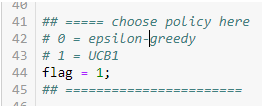

In [7]:
## =============== UCB1 eploration policy ==============
## function for recording how many times actions is taken
n_action = np.zeros(action_size)
def action_n_times(val):
    n_action[val]+=1;

## upper confidence
def Ut_a(step,na):
    # derived from UCB1 equation - see references at bottom
    if na == 0:
        # assume na=0 means infinity and have higher chance to be choosen as next action
        return 1000 
    else:
        # step+1 to handle loop that start from 0
        return np.square(2*np.log(step+1)/na)
        #return np.square(2*np.log(step+1)/(na))
    

# function for UCB1
def UCB_1(state,step):
    newProb = np.zeros(action_size, dtype=float)
    newProb = copy.deepcopy( np.array( qtable[state, :] ) )
    
    #UCB1 equation
    for x in range(0,action_size):
           newProb[x] = newProb[x]+Ut_a(step,n_action[x])
            
    action = np.argmax(newProb)
    return action

### ========== epsilon-greedy ==============
# get next action, using epsilon greedy policy
def getNextAction(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        #action = greedy_action(state)
        action = np.argmax(qtable[state, :])
    return action

## ============= train RL =================

## ===== choose policy here
# 0 = epsilon-greedy
# 1 = UCB1 
flag = 1;
## =======================

for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    
    for step in range(max_steps):
        
        #******************Part2: Implement SARSA by yourself*******************

        if flag == 0:
## ============== policy - epsilon greedy ===========
            action = getNextAction(state)
            # get next env steps
            new_state, reward, done, info = env.step(action)
            #get next actions for sarsa equation
            new_action = getNextAction(new_state)
        elif flag == 1:
## ============= policy - UCB1 ============        
            action = UCB_1(state,step)
            action_n_times(action) ## record action that choosen
            new_state, reward, done, info = env.step(action)
            new_action = UCB_1(new_state,step+1) # get next action
        
        # Update Q table with sarsa equation
        predict = qtable[state, action]
        target = reward + gamma * qtable[new_state, new_action]
        qtable[state, action] = qtable[state, action] + learning_rate * (target - predict)
        #***********************************************************************
        
        # Our new state is state
        state = new_state
        
        # If done : finish episode
        if done == True: 
            break
    
    #**************Part3: Try different epsilon reduction methods by yourself****************    
    # Reduce epsilon (because we need less and less exploration)    
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

In [8]:
env.reset()
rewards = []

for episode in range(total_test_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0

    for step in range(max_steps):
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            #print ("Score", total_rewards)
            break
        state = new_state
env.close()
print ("SARSA | Score over time: " +  str(sum(rewards)/total_test_episodes))

SARSA | Score over time: 8.48


In [ ]:
#DEBUG

print(step)
print(qtable[2, :])

#print(str(np.random.randint(0, action_size)))
#print(str(random.uniform(0,1)))
#print(str(np.random.rand()))
#random.uniform(0,1)

# Demo (SARSA)

In [ ]:
env.reset()
rewards = []
perf=0
score=0

for episode in range(total_demo_episodes):
    clear_screen(0)
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0

    for step in range(max_steps):
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            #print ("Score", total_rewards)
            log_progress(env, reward=reward, total_reward=total_rewards, delay=0.5, message=perf_message(episode, perf))
            break
        log_progress(env, reward=reward, total_reward=total_rewards, delay=0.5, message=perf_message(episode, perf))
        state = new_state
        
    clear_screen(0)  
    score += total_rewards
    perf = score/(episode + 1)
    
env.close()
print ("Score", total_rewards)

# Questions:

Q1: Which policy algorithm do you use?

Epsilon-Greedy or UCB1 you can try one of them and commenting the other one, both of them is running with score over time above 8.0

you can see the average result in here :https://docs.google.com/spreadsheets/d/1mBEnJPiyEh2r7CsEzBYaoJIqQjB4RBunJ4vgQ8jsiMk/edit?usp=sharing

which shown that UCB1 perform better in terms of score over time above 8.0 and average

Q2: Briefly introduce SARSA algorithm.

Sarsa is an on-policy control method for RL learning to fill Q-table, An on-policy control method chooses the action for each state during learning by following a certain policy (mostly the one it is evaluating itself, like in policy iteration). 

Sarsa equation
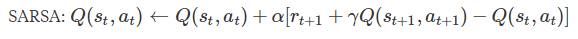

policy equation ===============

--Epsilon-Greedy ------------------
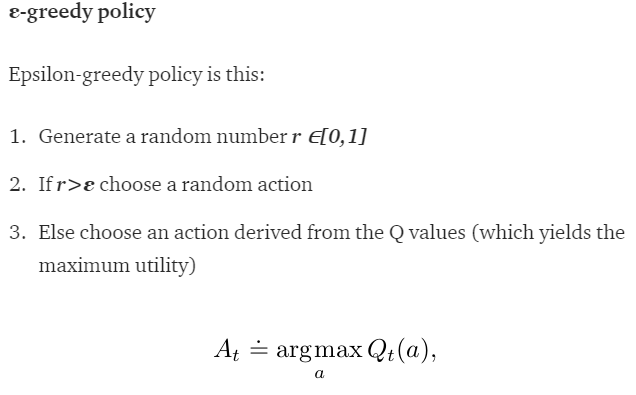

--UCB1-------------------------
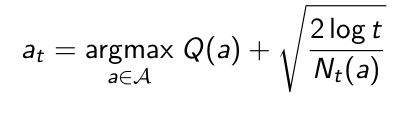

Q3: Discuss the difference between Q-Learning and SARSA algorithm.

#The main difference between Q-Learning and Sarsa are Q-Learning is off-policy and sarsa is on-policy, which also means they have different equation for update Q-table

#### References
#https://www.quora.com/What-is-the-difference-between-Q-learning-and-SARSA-learning
#https://medium.com/swlh/introduction-to-reinforcement-learning-coding-sarsa-part-4-2d64d6e37617
#https://towardsdatascience.com/reinforcement-learning-temporal-difference-sarsa-q-learning-expected-sarsa-on-python-9fecfda7467e
###### UCB referrences
#https://www.coursera.org/lecture/practical-rl/ucb-1-fr4uU | minute 3:00
#https://towardsdatascience.com/reinforcement-learning-demystified-exploration-vs-exploitation-in-multi-armed-bandit-setting-be950d2ee9f6
#https://github.com/lilianweng/multi-armed-bandit/blob/master/solvers.py#L45
